In [1]:
%matplotlib inline
import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

THIS_DIR = getcwd()
CLASS_DIR = abspath(join(THIS_DIR, '../../..', 'dsnclasses'))
sys.path.append(CLASS_DIR)

import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output

from ENOnormalexp import ENO
from CAPMr3exp import CAPM
# from NN6a import DQN as DQN
# from globalvar import *

In [2]:
# seed = 228
# random.seed(seed)
# torch.manual_seed(seed)
# np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# Hyper Parameters
BATCH_SIZE = 24
LR = 0.01          # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
LAMBDA = 0.9                # parameter decay
TARGET_REPLACE_ITER = 24*7*4*12    # target update frequency (every two months)
MEMORY_CAPACITY     = 24*7*4*12*3      # store upto six month worth of memory   

N_ACTIONS = 10 #no. of duty cycles (0,1,2,3,4)
N_STATES = 3 #number of state space parameter [batt, enp, henergy]

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# from globalvar import *

HIDDEN_LAYER = 100

#Class definitions for NN model and learning algorithm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        
        self.fc2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.fc2.weight.data.normal_(0, 0.1)   # initialization
        
        self.fc3 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.fc3.weight.data.normal_(0, 0.1)   # initialization

        self.out = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value
    
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory [mem: ([s], a, r, [s_]) ]
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
    
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] # return the argmax index

        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1
    
    def store_day_transition(self, transition_rec):
        data = transition_rec
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory= np.insert(self.memory, index, data,0)
        self.memory_counter += transition_rec.shape[0]

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [5]:
def test_model(TEST_LOCATION, TEST_YEAR, MODELFILE, dqn):

    print('\nYear run test (Greedy Policy)')

#     dqn = DQN()
    capm = CAPM(TEST_LOCATION,TEST_YEAR, shuffle=False, trainmode=False) #if reset is True
    capm.eno = ENO(TEST_LOCATION,TEST_YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    # load the required model
    dqn.eval_net.load_state_dict(torch.load(MODELFILE))
    dqn.eval_net.eval()
    print('Model Used: ',MODELFILE)

    s, r, day_end, year_end = capm.reset()
    yr_test_record = np.empty(4)

    while True:
        a = dqn.choose_greedy_action(s)

        #state = [batt, enp, henergy, fcast]
        yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

        # take action
        s_, r, day_end, year_end = capm.step(a)

        if year_end:
            print("End of Test")
            break

        s = s_

    yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
    NO_OF_DAYS = capm.eno.NO_OF_DAYS
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]
    
    #Plot the reward and battery for the entire year run
    title = TEST_LOCATION.upper() + ',' + str(TEST_YEAR)
    print('Average Reward for',title, '=', np.mean(yr_test_reward_rec))

    fig = plt.figure(figsize=(24,3))
    fig.suptitle(title, fontsize=15)

#     ax1 = fig.add_subplot(211)
#     ax1.plot(yr_test_reward_rec)
#     ax1.set_title("\n\nYear Run Reward")
#     ax1.set_ylim([-3,1])

    ax2 = fig.add_subplot(111)
    ax2.plot(yr_test_record[:,0],'r')
    ax2.set_title("\n\nYear Run Battery")
    ax2.set_ylim([0,1])
    plt.sca(ax2)
    plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

    fig.tight_layout()
    plt.show()    
    return 0


TRAINING IN PROGRESS

Iteration 0:  TOKYO, 2004 
Average Reward 		=   -2.971


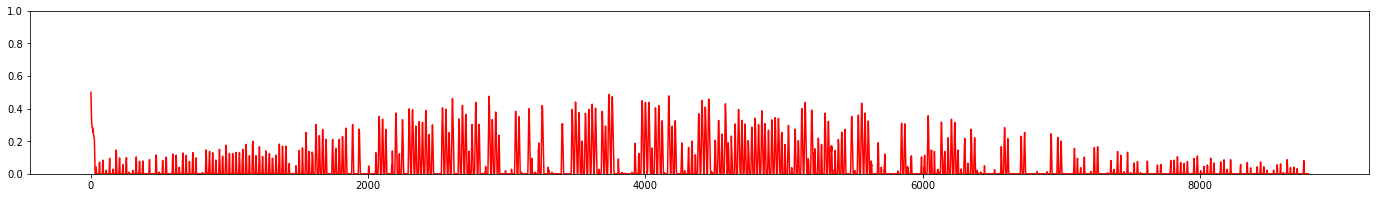

Iteration 1:  TOKYO, 2005 
Average Reward 		=   -2.983


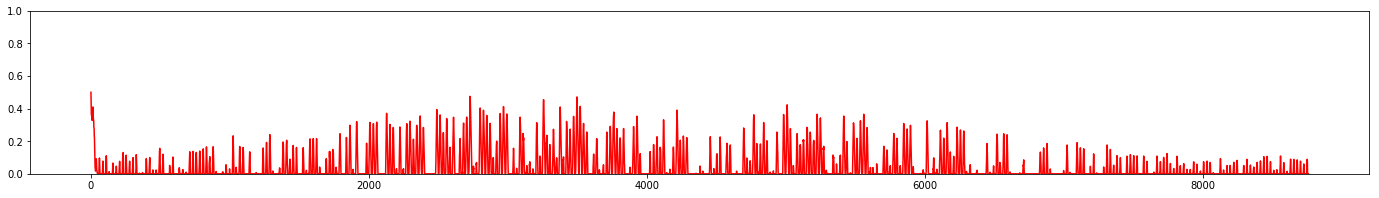

Iteration 2:  TOKYO, 2006 
Average Reward 		=   -2.760


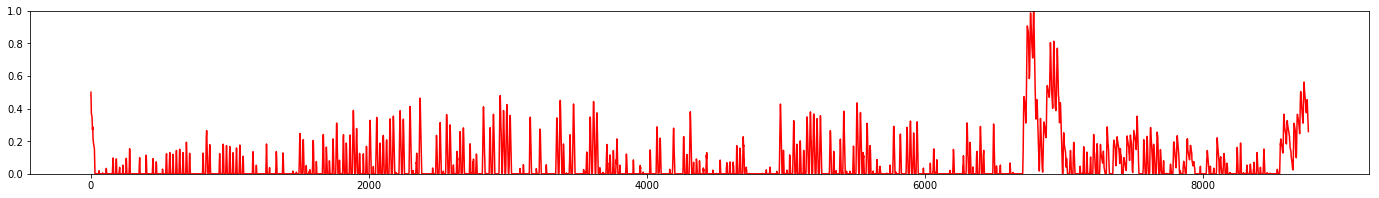

Iteration 3:  TOKYO, 2007 
Average Reward 		=   -2.057


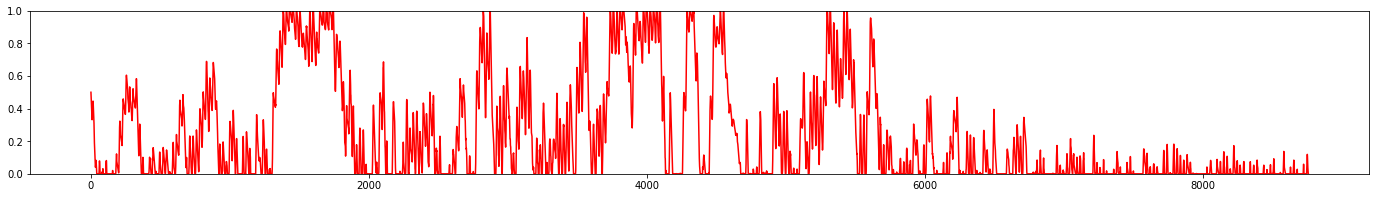

Iteration 4:  TOKYO, 2008 
Average Reward 		=   -2.091


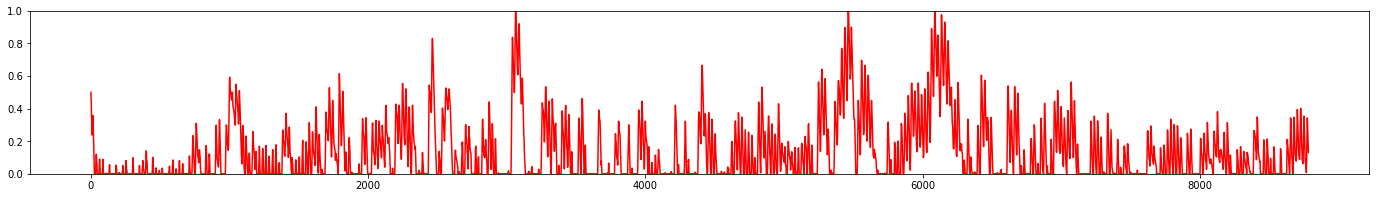

Iteration 5:  TOKYO, 2009 
Average Reward 		=   -1.901


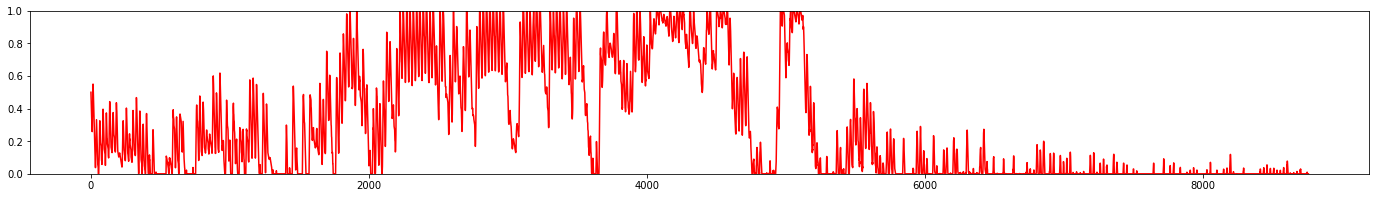

Iteration 6:  TOKYO, 2010 
Average Reward 		=   -1.922


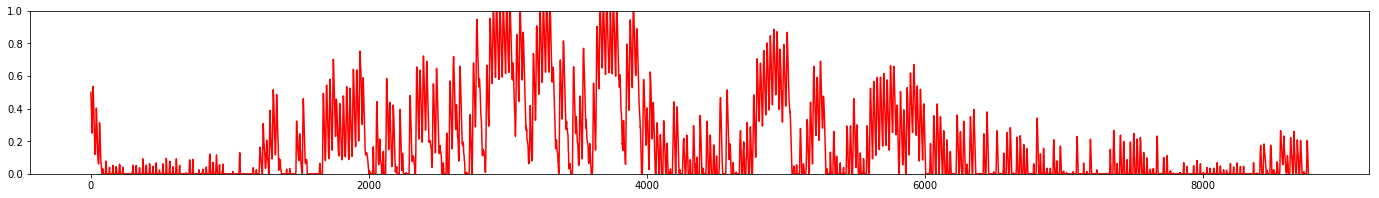

Iteration 7:  TOKYO, 2011 
Average Reward 		=   -2.200


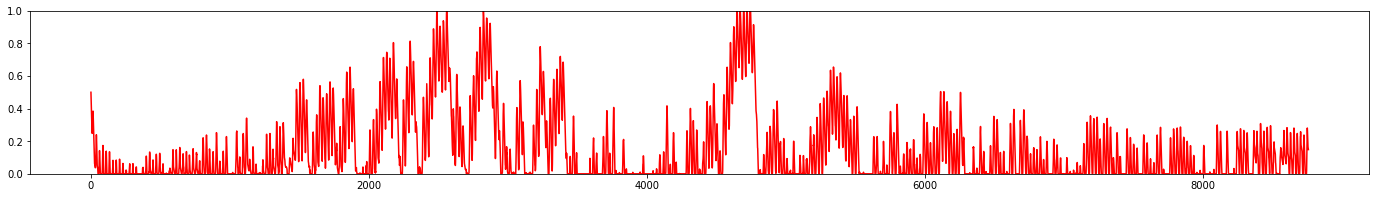

Iteration 8:  TOKYO, 2012 
Average Reward 		=   -0.811


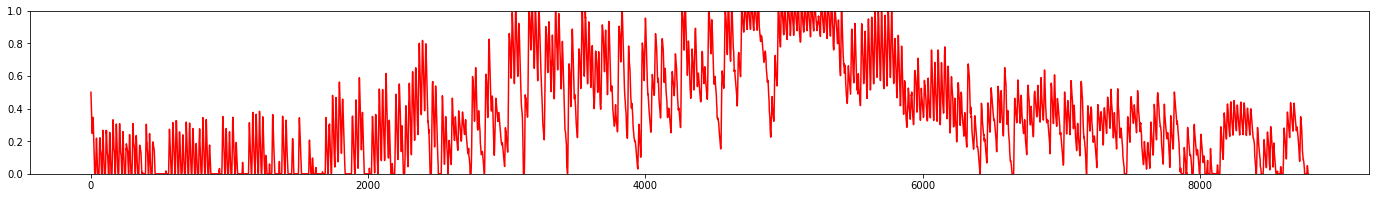

Iteration 9:  TOKYO, 2013 
Average Reward 		=   -0.007


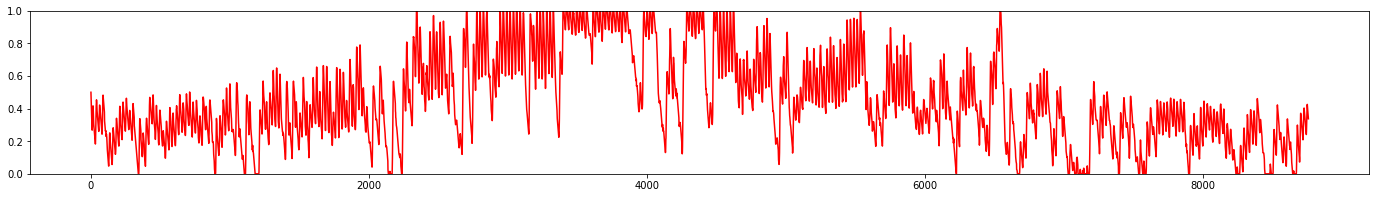

Iteration 10:  TOKYO, 2014 
Average Reward 		=   -1.135


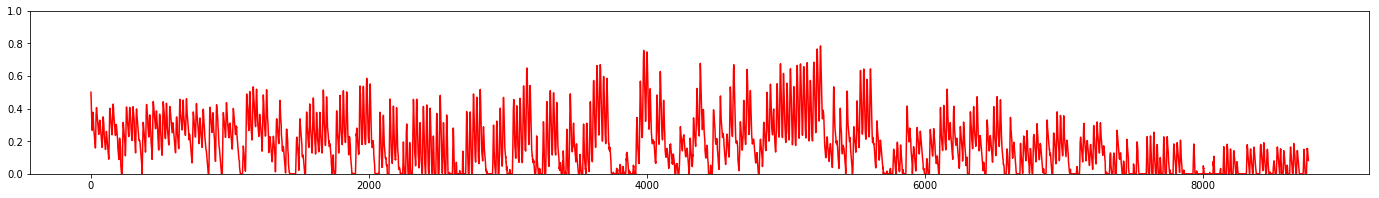

Iteration 11:  TOKYO, 2004 
Average Reward 		=   -1.624


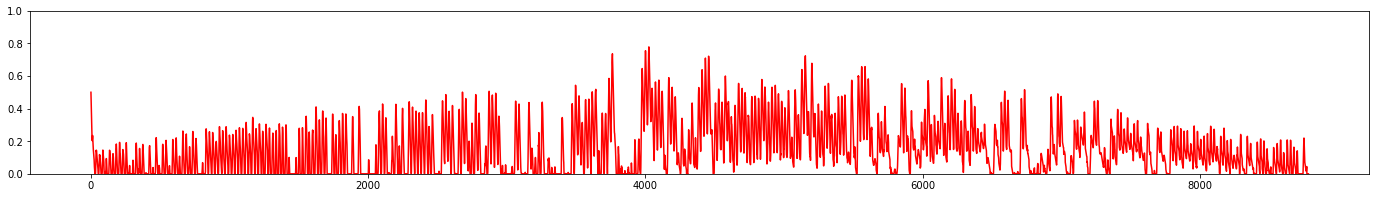

Iteration 12:  TOKYO, 2005 
Average Reward 		=   -1.765


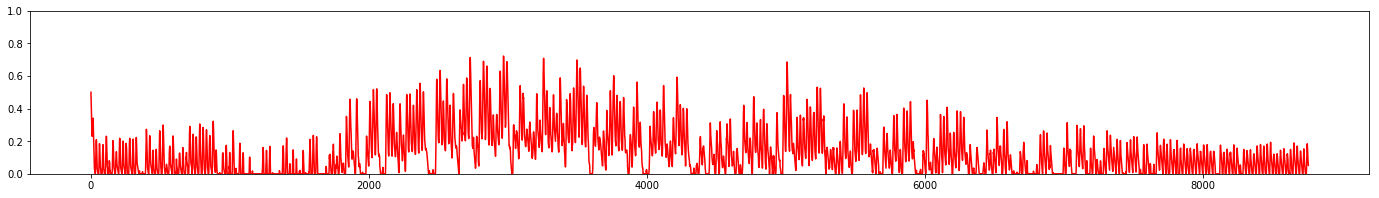

Iteration 13:  TOKYO, 2006 
Average Reward 		=   -2.668


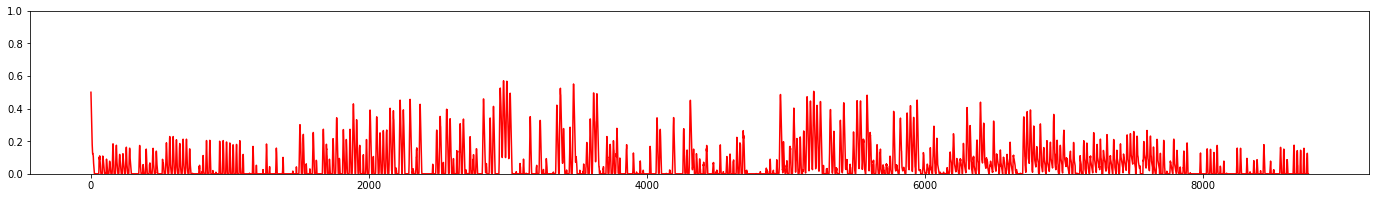

Iteration 14:  TOKYO, 2007 


KeyboardInterrupt: 

In [6]:
#TRAIN USING data from TOKYO  FROM 2005 to 2015 on pre-trained model
#Simulating actual working
#No Random Battery but battery is reset
#No Shuffle
PRETRAIN = 'bestQ5UUSPW4.pt'
dqn = DQN()
# dqn.eval_net.load_state_dict(torch.load(PRETRAIN))
# dqn.eval_net.eval()
NO_OF_ITERATIONS = 30

best_iteration = -1
best_avg_reward = -1000 #initialize best average reward to very low value
PFILENAME = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(8)) #create random filename
BFILENAME = "best"+PFILENAME + ".pt" #this file stores the best model
TFILENAME = "terminal"+PFILENAME + ".pt" #this file stores the last model

avg_reward_rec = [] #record the yearly average rewards over the entire duration of training
print('\nTRAINING IN PROGRESS\n')
Y_EAR = 2004
for iteration in range(NO_OF_ITERATIONS):
    LOCATION = 'tokyo' # random.choice(['tokyo','wakkanai','minamidaito'])
    YEAR = Y_EAR + iteration%11#random.choice(np.arange(2005,2015))
    capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object
#     clear_output()
    print('Iteration {}:  {}, {} '.format(iteration, LOCATION.upper(), YEAR))

    s, r, day_end, year_end = capm.reset()
    yr_record = np.empty(4)

    record = np.empty(4) #record for battery, henergy, reward and action
    transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day

    while True:
        a = dqn.choose_action(s)

        # present state = [batt, enp, henergy]
        record = np.vstack((record, [s[0],s[2],r, a])) # record battery, henergy, reward and action for troubleshooting
                                                       # However, we are interested only in the reward
        yr_record = np.vstack((yr_record, [s[0],s[2],r, a]))

        # take action
        s_, r, day_end, year_end = capm.step(a)
        
        temp_transitions = np.hstack((s, [a, r], s_))
        transition_rec[capm.eno.hr-1,:] = temp_transitions

        if (day_end):
            transition_rec[:,5] = r #broadcast reward to all states
            decay_factor = [i for i in (LAMBDA**n for n in reversed(range(0, capm.eno.TIME_STEPS)))]
            transition_rec[:,5] = transition_rec[:,5] * decay_factor #decay reward proportionately
            dqn.store_day_transition(transition_rec)
#             if (capm.BMIN == capm.batt or capm.BMAX == capm.batt):
#                 capm.batt = capm.BOPT

        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
#             print("Learning:",capm.eno.year, capm.eno.day)

        if (year_end):
    #             print("End of Year")
            break

        # transition to new state
        s = s_

    record = np.delete(record, 0, 0) #remove the first row which is garbage
    reward_rec = record[:,2] #extract reward information from the record array
    reward_rec = reward_rec[reward_rec != 0] #remove all zero rewards in the middle of the days
    print("Average Reward \t\t= {:8.3f}".format(np.mean(reward_rec)))

#     # Check if reward beats the High Score and possible save it    
#     if (iteration > 19): #save the best models only after 20 iterations
#         print("Best Score \t = {:8.3f} @ Iteration No. {}".format(best_avg_reward, best_iteration))
#         if(best_avg_reward < np.mean(reward_rec)):
#             best_iteration = iteration
#             best_avg_reward = np.mean(reward_rec)
#             print("Saving Model")
#             torch.save(dqn.eval_net.state_dict(), BFILENAME)
#     else:
#         print("\r")
    # Log the average reward in avg_reward_rec
    avg_reward_rec = np.append(avg_reward_rec, np.mean(reward_rec))
    
    yr_record = np.delete(yr_record, 0, 0) #remove the first row which is garbage
#     NO_OF_DAYS = capm.eno.NO_OF_DAYS
#     yr_reward_rec = yr_record[:,2]
#     yr_reward_rec = yr_reward_rec[yr_reward_rec != 0]
    fig = plt.figure(figsize=(24,3))
    plt.plot(yr_record[:,0],'r')
    plt.ylim([0,1])
    plt.show()

    # End of training
# Save the last model
# torch.save(dqn.eval_net.state_dict(), TFILENAME) 

# Plot the average reward log
plt.plot(avg_reward_rec,'b')
plt.ylim([-3,1])


In [ ]:
#BFILENAME -> loads the best model
#TFILENAME -> loads the last model
MODELFILE = BFILENAME
TEST_LOCATION = 'tokyo'
dqn = DQN()
for TEST_YEAR in np.arange(2015,2018):
    test_model(TEST_LOCATION, TEST_YEAR, MODELFILE, dqn)

In [ ]:
#BFILENAME -> loads the best model
#TFILENAME -> loads the last model
MODELFILE = TFILENAME
TEST_LOCATION = 'tokyo'
dqn = DQN()
for TEST_YEAR in np.arange(2016,2018)
    test_model(TEST_LOCATION, TEST_YEAR, MODELFILE, dqn)

In [ ]:
# TEST_YEAR = 2018
# for TEST_LOCATION in ['tokyo','wakkanai','minamidaito']:
#     test_model(TEST_LOCATION, TEST_YEAR)

In [ ]:
# dqn = DQN()
# capm = CAPM(TEST_LOCATION,TEST_YEAR, shuffle=False, trainmode=False) #if reset is True
# capm.eno = ENO(TEST_LOCATION,TEST_YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
# capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object


# # load the required model
# dqn.eval_net.load_state_dict(torch.load(MODELFILE))
# dqn.eval_net.eval()
# print('Model Used: ',MODELFILE)

# s, r, day_end, year_end = capm.reset()
# yr_test_record = np.empty(4)

# while True:
#     a = dqn.choose_greedy_action(s)

#     #state = [batt, enp, henergy, fcast]
#     yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

#     # take action
#     s_, r, day_end, year_end = capm.step(a)
    
# #     if day_end:
# #         if (capm.BMIN ==capm.batt or capm.batt == capm.BMAX):
# #             capm.batt = capm.BOPT
        

#     if year_end:
#         print("End of Test")
#         break

#     s = s_

# yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage

# #Plot the reward and battery for the entire year run
# title = TEST_LOCATION.upper() + ',' + str(TEST_YEAR)

# NO_OF_DAYS = capm.eno.NO_OF_DAYS
# yr_test_reward_rec = yr_test_record[:,2]
# yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]
# print('Average Reward for',title, '=', np.mean(yr_test_reward_rec))


# fig = plt.figure(figsize=(24,10))
# fig.suptitle(title, fontsize=15)

# #     ax1 = fig.add_subplot(211)
# #     ax1.plot(yr_test_reward_rec)
# #     ax1.set_title("\n\nYear Run Reward")
# #     ax1.set_ylim([-3,1])

# ax2 = fig.add_subplot(111)
# ax2.plot(yr_test_record[:,0],'r')
# ax2.set_title("\n\nYear Run Battery")
# ax2.set_ylim([0,1])
# plt.sca(ax2)
# plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

# fig.tight_layout()
# plt.show()
    

In [ ]:
# #Plot the reward and battery for the entire year run on a day by day basis
# title = TEST_LOCATION.upper() + ',' + str(TEST_YEAR)
# TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
# for DAY in range(150,170):#capm.eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     daytitle = title + ' - DAY ' + str(DAY)
#     fig = plt.figure(figsize=(16,4))
#     st = fig.suptitle(daytitle)

#     ax2 = fig.add_subplot(121)
#     ax2.plot(yr_test_record[START:END,1],'g')
#     ax2.set_title("HARVESTED ENERGY")
#     plt.xlabel("Hour")
#     ax2.set_ylim([0,1])

#     #plot battery for year run
#     ax1 = fig.add_subplot(122)
#     ax1.plot(TIME_AXIS,yr_test_record[START:END,0],'r') 
# #     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*capm.BOPT/capm.BMAX,'r--')
#     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*yr_test_record[START,0],'r--')
#     ax1.text(0.1, 0.2, "BINIT = %.2f\n" %(yr_test_record[START,0]),fontsize=11, ha='left')
#     ax1.text(0.1, 0.4, "TENP = %.2f\n" %(capm.BOPT/capm.BMAX-yr_test_record[END,0]),fontsize=11, ha='left')
#     ax1.text(0.1, 0.3, "BMEAN = %.2f\n" %(np.mean(yr_test_record[START:END,0])),fontsize=11, ha='left')



#     ax1.set_title("YEAR RUN TEST")
#     if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
#         ax1.text(0.1, 0, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=13, ha='left')
#     plt.xlabel("Hour")
#     ax1.set_ylabel('Battery', color='r',fontsize=12)
#     ax1.set_ylim([0,1])

#     #plot actions for year run
#     ax1a = ax1.twinx()
#     ax1a.plot(yr_test_record[START:END,3])
#     ax1a.set_ylim([0,N_ACTIONS])
#     ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)

#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()